In [249]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn import tree

from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score


from numpy import mean
from numpy import std
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer

In [114]:
def symmetric_mean_absolute_percentage_error(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)



Preprocessing

In [164]:
def remove_outliers(df, target_name):
    y=df[target_name]
    data_mean, data_std = mean(y), std(y)
# identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers

    df_ = df[df[target_name].between(lower, upper)]
    return df_

def scaler(df):
    ss=StandardScaler()
    df_=ss.fit_transform(df)
    return df_



In [228]:
def create_metrics_tag():
    return {'Specific': [], 'MAPE': [], 'SMAPE':[],  'MSLE': [], 'MSE':[], 'MAE':[], 'R2':[]}

def get_metrics(a, p, name):

    metrics = {'MAPE' : mean_absolute_percentage_error, 'SMAPE': symmetric_mean_absolute_percentage_error, 'MSLE': mean_squared_log_error, 'MSE': mean_squared_error, 'MAE': mean_absolute_error, 'R2':r2_score}
    tags=create_metrics_tag()

    for metric in metrics.keys():
        func=metrics[metric]
        val =func(a, p)
        tags[metric].append(val)

    tags['Specific'].append(name)
    df_ = pd.DataFrame(tags)
    return df_


In [220]:
def preprocess(df,scal= False, dropN= None ):

    df_=df.copy()
    if(dropN):
        df_=df_.drop(dropN, axis=1)
    df_=pd.get_dummies(df, drop_first= True)
    x=df_.copy().drop('charges', axis=1)
    y=df_['charges'].copy()
    if(scal):
        x = scaler(x)
    return x, y

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

Model evaluation

In [283]:
df = pd.read_csv('archive\insurance.csv')

X,y=preprocess(df, scal=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)



In [277]:
def getModelDIc(name, model, powtransform= False, drop=None):
    dict={'model': model, 'powerTransform': powtransform, 'drop': drop}
    return dict

Szukamy optymalnych parametrów poprzez kros - walidacje

In [289]:
metrics = pd.DataFrame(create_metrics_tag())

models={}

name='Liniowy '
model=LinearRegression()
modelDict= getModelDIc(name, model)
models[name]=modelDict


name='Liniowy Transformed'
model=LinearRegression()
modelDict= getModelDIc(name, model, powtransform=True)
models[name]=modelDict

name='Liniowy Drop region '
model=LinearRegression()
modelDict= getModelDIc(name, model, powtransform=True, drop=['region_northwest','region_southeast', 'region_southwest'])
models[name]=modelDict


name='Drzewo'
model=DecisionTreeRegressor(max_depth=4)
modelDict= getModelDIc(name, model)
models[name]=modelDict

name='Drzewo Transformed'
model=DecisionTreeRegressor(max_depth=4)
modelDict= getModelDIc(name, model, powtransform=True)
models[name]=modelDict


name='RandomForest'
model=RandomForestRegressor(n_estimators=100, max_depth=4)
modelDict= getModelDIc(name, model)
models[name]=modelDict

name='RandomForest drop region'
model=RandomForestRegressor(n_estimators=100, max_depth=4, )
modelDict= getModelDIc(name, model, drop=['region_northwest','region_southeast', 'region_southwest'])
models[name]=modelDict

name='RandomForest drop region transformed'
model=RandomForestRegressor(n_estimators=100, max_depth=4, )
modelDict= getModelDIc(name, model, drop=['region_northwest','region_southeast', 'region_southwest'], powtransform= True)
models[name]=modelDict

for modelN in models:
    X_train_, X_test_, y_train_, y_test_= X_train, X_test, y_train, y_test
    model=models[modelN]['model']
    if(models[modelN]['powerTransform']):
        #power = PowerTransformer()
        #y_train_=power.fit_transform(np.expand_dims(y_train, axis=1))
        y_train_=np.log1p(y_train_)
    if(models[modelN]['drop']):
        X_train_=X_train_.drop(models[modelN]['drop'], axis=1)
        X_test_=X_test_.drop(models[modelN]['drop'], axis=1)

    model.fit(X_train_, y_train_)

    y_pred= model.predict(X_test_)
    y_pred=np.where(y_pred>0, y_pred,0 )
    if(models[modelN]['powerTransform']):
        #y_pred=power.inverse_transform(y_pred.reshape(-1,1))
        #y_pred=np.squeeze(y_pred)
        y_pred=np.expm1(y_pred)
    
    metric=get_metrics(y_test_, y_pred, modelN)
    metrics = pd.concat([metrics, metric]).reset_index(drop=True)
metrics


,Specific,MAPE,SMAPE,MSLE,MSE,MAE,R2
0,Liniowy,0.462645,40.022008,1.141394,3.354208e+07,4170.045013,0.783946
1,Liniowy Transformed,0.273935,25.713600,0.175509,6.105960e+07,3888.443159,0.606698
2,Liniowy Drop region,0.281726,26.251528,0.181316,6.157757e+07,3968.144439,0.603362
3,Drzewo,0.331120,28.100890,0.178438,2.109348e+07,2697.765431,0.864131
4,Drzewo Transformed,0.210674,21.251869,0.134321,2.094784e+07,2332.941205,0.865069
5,RandomForest,0.325019,28.042662,0.170493,1.987119e+07,2589.725811,0.872004
6,RandomForest drop region,0.330340,28.330881,0.172966,1.965678e+07,2587.589704,0.873385
7,RandomForest drop region transformed,0.185196,19.129588,0.128695,1.963956e+07,2120.566572,0.873496


In [275]:
x_train.columns

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

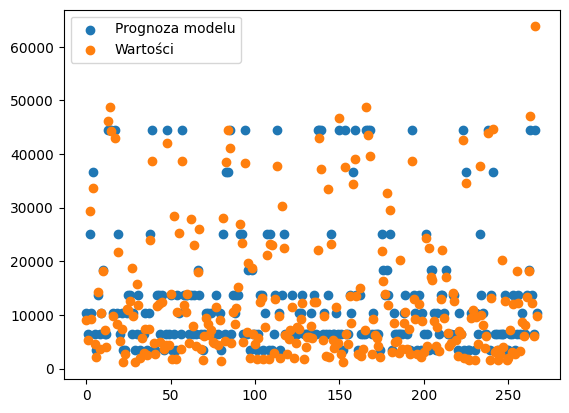

In [41]:



plt.scatter(range(len(y_pred)), y_pred, label = 'Prognoza modelu')
plt.scatter(range(len(y_pred)), y_test, label = 'Wartości')
plt.legend()